# Mecánica de Medios Continuos
## Por Jorge I. Zuluaga
### Cuadernos de exploración numérica
### **CFD: flujo estacionario 1D con vorticidad**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

### Programa

In [2]:
%%file flujo-vorticidad.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

//Crea una matriz dinámicamente
double **matriz(int Nx,int Ny){
  int i;
  double **M;
  M=(double**)malloc(Nx*sizeof(double*));
  for(i=0;i<Nx;i++){
      M[i]=(double*)malloc(Ny*sizeof(double));
  }
  return M;
}

//Programa
int main(int argc,char *argv[])
{
  /////////////////////////////////////////////////////////////
  //Entradas
  /////////////////////////////////////////////////////////////
  int ip=1;
  int Nxmax=atoi(argv[ip++]);
  int Nymax=atoi(argv[ip++]);
  double U=atof(argv[ip++]);//Velocidad del flujo
  double omega=atof(argv[ip++]);//Parametro de relajación
  int X=atoi(argv[ip++]);
  int H=atoi(argv[ip++]);
  int W=atoi(argv[ip++]);
  int Niter=atoi(argv[ip++]);
 
  printf("Velocidad del flujo [uh]: %lf\n",U);
  printf("Número de iteraciones: %d\n",Niter);
  printf("Posición del objeto [uh]: %d\n",X);
  printf("Dimensiones del objeto: %d x %d\n",H,W);
 
  /////////////////////////////////////////////////////////////
  //Constantes
  /////////////////////////////////////////////////////////////
  double h=1,nu=1;
  double R = U*h/nu; // Reynold number in normal units
  printf("Número de Reynolds: %lf\n",R);
  
  /////////////////////////////////////////////////////////////
  //Campos
  /////////////////////////////////////////////////////////////
  double **u=matriz(Nxmax+1,Nymax+1);
  FILE *uf = fopen("corriente.dat","w"); 
  double **w=matriz(Nxmax+1,Nymax+1);
  FILE *wf = fopen("vorticidad.dat","w"); 
  FILE *xf = fopen("xs.dat","w"); 
  FILE *yf = fopen("ys.dat","w"); 
  
  int i, j, iter; 
  double r1, r2, r1med, r2med;
  
  /////////////////////////////////////////////////////////////
  //Condiciones iniciales
  /////////////////////////////////////////////////////////////
  printf("Inicializando...\n");
  //Todo
  for ( i=0; i <= Nxmax; i++ ) { 
    for ( j=0; j <= Nymax; j++ ) {
      w[i][j] = 0.;  
      u[i][j] = j*U;
    }
  } 
    
  //Superficie
  for ( i=0; i <= Nxmax; i++ ) { 
    u[i][Nymax] = u[i][Nymax-1] + U*h; 
    w[i][Nymax-1] = 0. ; 
  }
  
  //Entrada
  for ( j=0; j <= Nymax; j++ ) { 
    u[1][j] = u[0][j];
    w[0][j] = 0. ; 
  }     
  //Linea central
  for ( i=0; i <= Nxmax; i++ ){                                       
    if ((i <= X)||(i>=X + W)) {  
        u[i][0] = 0.;  
        w[i][0] = 0. ; 
      }
  }
  //Salida
  for ( j=1; j <= Nymax-1; j++ ) {                                        
    w[Nxmax][j] = w[Nxmax-1][j]; 
    u[Nxmax][j] = u[Nxmax-1][j]; 
  }

  /////////////////////////////////////////////////////////////
  //Relajación
  /////////////////////////////////////////////////////////////
  printf("Relajando...\n");
  iter = 0;
  while (iter <= Niter){ 
    iter++ ;  
    //-------------------------------------------------
    //Vuelve y fija condiciones sobre el objeto
    //-------------------------------------------------
    // Beam sides
    for ( j=0; j <= H; j++ ) {
        // Front side                                    
        w[X][j] = -2*u[X-1][j]/(h*h);
        // Back side
        w[X + W][j] = -2*u[X + W + 1][j]/(h*h);                          
    }
    // Top
    for ( i=X; i <= X + W; i++ ) 
      w[i][H-1] = -2*u[i][H]/(h*h);               
    
    for ( i=X; i <= X + W; i++ ) {
      for ( j=0; j <= H; j++ ) {
        // Front
        u[X][j] = 0. ;
        // Back                                                   
        u[X + W][j] = 0. ; 
        // Top                                                 
        u[i][H] = 0;                                                           
      }
    }                               

    //-------------------------------------------------
    //Relajación de la función de corriente
    //-------------------------------------------------
    r1med=0;
    for ( i=1; i <= Nxmax-1; i++ )  {                        
      for ( j=1; j <= Nymax-1; j++ ) {
        r1 = omega*((u[i + 1][j] + u[i-1][j] + u[i][j + 1] + u[i][j-1]
          + h*h*w[i][j])*(1./4.)-u[i][j]); 
        u[i][j] += r1;
        r1med+=fabs(r1);
      }
    } 
    r1med/=((Nxmax-1)*(Nymax-1));
    //-------------------------------------------------
    //Relajación de la vorticidad
    //-------------------------------------------------
    r2med=0;
    for ( i=1; i < Nxmax-1; i++ )  {                               
      for ( j=1; j < Nymax-1; j++ ) {
        r2 = omega*((w[i + 1][j] + w[i-1][j] + w[i][j + 1] + w[i][j-1]-
            (R/4.)*((u[i][j + 1]-u[i][j-1])*(w[i + 1][j]-w[i-1][j])-
            (u[i + 1][j]-u[i-1][j])*(w[i][j+1]-w[i][j-1])))/4. -w[i][j]); 
        w[i][j]  += r2;         
        r2med+=fabs(r2);
      } 
    } 
    r2med/=((Nxmax-1)*(Nymax-1));
  }//Fin del ciclo de relajación
 
  //Generando el campo de velocidades
  printf("Campo de velocidades...\n");
  double **vx=matriz(Nxmax+1,Nymax+1);
  FILE *vxf = fopen("vxs.dat","w"); 
  double **vy=matriz(Nxmax+1,Nymax+1);
  FILE *vyf = fopen("vys.dat","w"); 
  //En el core
  for ( i=1; i < Nxmax; i++ ) {                         
    for ( j=1; j < Nymax; j++ ) {   
      vx[i][j]=(u[i][j+1]-u[i][j-1])/(2*h);
      vy[i][j]=-(u[i+1][j]-u[i-1][j])/(2*h);
    }
  }
  for (i=0;i<=Nxmax;i++){
      vx[i][0]=vx[i][1];
      vy[i][0]=vy[i][1];
      vx[i][Nymax]=vx[i][Nymax-1];
      vy[i][Nymax]=vy[i][Nymax-1];
  }
  for (j=0;j<=Nymax;j++){
      vx[0][j]=vx[1][j];
      vy[0][j]=vy[1][j];
      vx[Nxmax][j]=vx[Nxmax-1][j];
      vy[Nxmax][j]=vy[Nxmax-1][j];
  }

  printf("Errores medios: ru = %e, rw = %e\n",r1med,r2med);
  printf("Guardando...\n");
  //Output
  for ( i=0; i <= Nxmax; i++ ) {                         
    for ( j=0; j <= Nymax; j++ ) {   
      fprintf(uf,"%lf ",u[i][j]);
      fprintf(wf,"%lf ",w[i][j]);
      fprintf(xf,"%d ",i);
      fprintf(yf,"%d ",j);
      fprintf(vxf,"%lf ",vx[i][j]);
      fprintf(vyf,"%lf ",vy[i][j]);
    }
    fprintf(uf,"\n");
    fprintf(wf,"\n");
    fprintf(xf,"\n");
    fprintf(yf,"\n");
    fprintf(vxf,"\n");
    fprintf(vyf,"\n");
  }//Fin guardado
 
}//Fin main

Writing flujo-vorticidad.c


Llamado y ejecución:

In [3]:
#Dimensiones de la región
Nx=70
Ny=20
#Velocidad
U=1
#Posición del obstáculo
X=20
#Dimensiones del obstáculo
H=8
W=8
#Parámetro de relajación
omega=0.1
Niter=10000

!gcc -lm flujo-vorticidad.c && time ./a.out $Nx $Ny $U $omega $X $H $W $Niter

Velocidad del flujo [uh]: 1.000000
Número de iteraciones: 10000
Posición del objeto [uh]: 20
Dimensiones del objeto: 8 x 8
Número de Reynolds: 1.000000
Inicializando...
Relajando...
Campo de velocidades...
Errores medios: ru = 1.031663e-04, rw = 3.241076e-04
Guardando...

real	0m0.575s
user	0m0.568s
sys	0m0.001s


Gráfico:

In [6]:
Vxs**2+Vys**2

array([[0.96652434, 0.96652434, 0.93247296, ..., 0.73978939, 0.86962543,
        0.86962543],
       [0.96652434, 0.96652434, 0.93247296, ..., 0.73978939, 0.86962543,
        0.86962543],
       [0.9687534 , 0.9687534 , 0.93611273, ..., 0.76625929, 0.8910733 ,
        0.8910733 ],
       ...,
       [1.03224568, 1.03224568, 1.06470817, ..., 1.24750291, 1.12573872,
        1.12573872],
       [1.03254417, 1.03254417, 1.06608172, ..., 1.23719715, 1.11673937,
        1.11673937],
       [1.03254417, 1.03254417, 1.06608172, ..., 1.23719715, 1.11673937,
        1.11673937]])

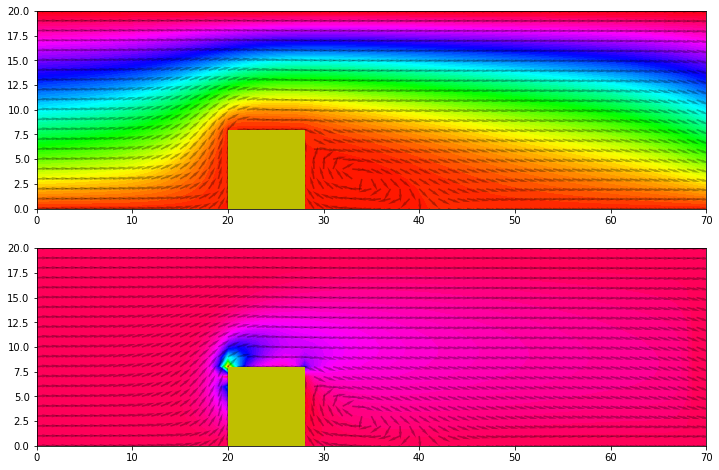

In [14]:
Xs=np.loadtxt("xs.dat").transpose()
Ys=np.loadtxt("ys.dat").transpose()
Vxs=np.loadtxt("vxs.dat").transpose()
Vys=np.loadtxt("vys.dat").transpose()
u=np.loadtxt("corriente.dat").transpose()
w=np.loadtxt("vorticidad.dat").transpose()

#Normaliza las velocidades para facilitar la representación del campo
Vmag=np.sqrt(Vxs**2+Vys**2)
Vxs/=Vmag
Vys/=Vmag

#Grafica
cmap="hsv"
scale=50
fig,axs=plt.subplots(2,1,figsize=(12,8))
c=axs[0].contourf(Xs,Ys,u,levels=100,cmap=cmap)
axs[0].quiver(Xs,Ys,Vxs,Vys,scale=scale,alpha=0.3,headwidth=2)
c=axs[1].contourf(Xs,Ys,w,levels=100,cmap=cmap)
axs[1].quiver(Xs,Ys,Vxs,Vys,scale=scale,alpha=0.3,headwidth=2)
for ax in axs:
  R=patches.Rectangle((X,0),width=W,height=H,color='y')
  ax.add_patch(R)

## Animación de la relajación

In [ ]:
%%file flujo-vorticidad_animacion.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

//Crea una matriz dinámicamente
double **matriz(int Nx,int Ny){
  int i;
  double **M;
  M=(double**)malloc(Nx*sizeof(double*));
  for(i=0;i<Nx;i++){
      M[i]=(double*)malloc(Ny*sizeof(double));
  }
  return M;
}

//Programa
int main(int argc,char *argv[])
{
  /////////////////////////////////////////////////////////////
  //Entradas
  /////////////////////////////////////////////////////////////
  int ip=1;
  int Nxmax=atoi(argv[ip++]);
  int Nymax=atoi(argv[ip++]);
  double U=atof(argv[ip++]);//Velocidad del flujo
  double omega=atof(argv[ip++]);//Parametro de relajación
  int X=atoi(argv[ip++]);
  int H=atoi(argv[ip++]);
  int W=atoi(argv[ip++]);
  int Niter=atoi(argv[ip++]);
  char nombre[100];
     
  printf("Velocidad del flujo [uh]: %lf\n",U);
  printf("Número de iteraciones: %d\n",Niter);
  printf("Posición del objeto [uh]: %d\n",X);
  printf("Dimensiones del objeto: %d x %d\n",H,W);
 
  /////////////////////////////////////////////////////////////
  //Constantes
  /////////////////////////////////////////////////////////////
  double h=1,nu=1;
  double R = U*h/nu; // Reynold number in normal units
  printf("Número de Reynolds: %lf\n",R);
  
  /////////////////////////////////////////////////////////////
  //Campos
  /////////////////////////////////////////////////////////////
  double **u=matriz(Nxmax+1,Nymax+1);
  FILE *uf = fopen("corriente.dat","w"); 
  double **w=matriz(Nxmax+1,Nymax+1);
  FILE *wf = fopen("vorticidad.dat","w"); 
  FILE *xf = fopen("xs.dat","w"); 
  FILE *yf = fopen("ys.dat","w"); 
  
  int i, j, iter; 
  double r1, r2, r1med, r2med;
  
  /////////////////////////////////////////////////////////////
  //Condiciones iniciales
  /////////////////////////////////////////////////////////////
  printf("Inicializando...\n");
  //Todo
  for ( i=0; i <= Nxmax; i++ ) { 
    for ( j=0; j <= Nymax; j++ ) {
      w[i][j] = 0.;  
      u[i][j] = j*U;
    }
  } 
    
  //Superficie
  for ( i=0; i <= Nxmax; i++ ) { 
    u[i][Nymax] = u[i][Nymax-1] + U*h; 
    w[i][Nymax-1] = 0. ; 
  }
  
  //Entrada
  for ( j=0; j <= Nymax; j++ ) { 
    u[1][j] = u[0][j];
    w[0][j] = 0. ; 
  }     
  //Linea central
  for ( i=0; i <= Nxmax; i++ ){                                       
    if ((i <= X)||(i>=X + W)) {  
        u[i][0] = 0.;  
        w[i][0] = 0. ; 
      }
  }
  //Salida
  for ( j=1; j <= Nymax-1; j++ ) {                                        
    w[Nxmax][j] = w[Nxmax-1][j]; 
    u[Nxmax][j] = u[Nxmax-1][j]; 
  }

  /////////////////////////////////////////////////////////////
  //Relajación
  /////////////////////////////////////////////////////////////
  printf("Relajando...\n");
  iter = 0;
  while (iter <= Niter){ 
    iter++ ;  
    //-------------------------------------------------
    //Vuelve y fija condiciones sobre el objeto
    //-------------------------------------------------
    // Beam sides
    for ( j=0; j <= H; j++ ) {
        // Front side                                    
        w[X][j] = -2*u[X-1][j]/(h*h);
        // Back side
        w[X + W][j] = -2*u[X + W + 1][j]/(h*h);                          
    }
    // Top
    for ( i=X; i <= X + W; i++ ) 
      w[i][H-1] = -2*u[i][H]/(h*h);               
    
    for ( i=X; i <= X + W; i++ ) {
      for ( j=0; j <= H; j++ ) {
        // Front
        u[X][j] = 0. ;
        // Back                                                   
        u[X + W][j] = 0. ; 
        // Top                                                 
        u[i][H] = 0;                                                           
      }
    }                               

    //-------------------------------------------------
    //Relajación de la función de corriente
    //-------------------------------------------------
    r1med=0;
    for ( i=1; i <= Nxmax-1; i++ )  {                        
      for ( j=1; j <= Nymax-1; j++ ) {
        r1 = omega*((u[i + 1][j] + u[i-1][j] + u[i][j + 1] + u[i][j-1]
          + h*h*w[i][j])*(1./4.)-u[i][j]); 
        u[i][j] += r1;
        r1med+=fabs(r1);
      }
    } 
    r1med/=((Nxmax-1)*(Nymax-1));
    //-------------------------------------------------
    //Relajación de la vorticidad
    //-------------------------------------------------
    r2med=0;
    for ( i=1; i < Nxmax-1; i++ )  {                               
      for ( j=1; j < Nymax-1; j++ ) {
        r2 = omega*((w[i + 1][j] + w[i-1][j] + w[i][j + 1] + w[i][j-1]-
            (R/4.)*((u[i][j + 1]-u[i][j-1])*(w[i + 1][j]-w[i-1][j])-
            (u[i + 1][j]-u[i-1][j])*(w[i][j+1]-w[i][j-1])))/4. -w[i][j]); 
        w[i][j]  += r2;         
        r2med+=fabs(r2);
      } 
    } 
    r2med/=((Nxmax-1)*(Nymax-1));

    //nombre="corriente-%d.dat"%iter
    //nombre=f"corriente-{iter}.dat"
    sprintf(nombre,"corriente-%d.dat",iter);
    uf=fopen(nombre,"w");
    for ( i=0; i <= Nxmax; i++ ) {                         
      for ( j=0; j <= Nymax; j++ ) {   
        fprintf(uf,"%lf ",u[i][j]);
      }
      fprintf(uf,"\n");
    }//Fin guardado
    fclose(uf);

  }//Fin del ciclo de relajación
 
  //Generando el campo de velocidades
  printf("Campo de velocidades...\n");
  double **vx=matriz(Nxmax+1,Nymax+1);
  FILE *vxf = fopen("vxs.dat","w"); 
  double **vy=matriz(Nxmax+1,Nymax+1);
  FILE *vyf = fopen("vys.dat","w"); 
  //En el core
  for ( i=1; i < Nxmax; i++ ) {                         
    for ( j=1; j < Nymax; j++ ) {   
      vx[i][j]=(u[i][j+1]-u[i][j-1])/(2*h);
      vy[i][j]=-(u[i+1][j]-u[i-1][j])/(2*h);
    }
  }
  for (i=0;i<=Nxmax;i++){
      vx[i][0]=vx[i][1];
      vy[i][0]=vy[i][1];
      vx[i][Nymax]=vx[i][Nymax-1];
      vy[i][Nymax]=vy[i][Nymax-1];
  }
  for (j=0;j<=Nymax;j++){
      vx[0][j]=vx[1][j];
      vy[0][j]=vy[1][j];
      vx[Nxmax][j]=vx[Nxmax-1][j];
      vy[Nxmax][j]=vy[Nxmax-1][j];
  }

  printf("Errores medios: ru = %e, rw = %e\n",r1med,r2med);
  printf("Guardando...\n");
  //Output
  for ( i=0; i <= Nxmax; i++ ) {                         
    for ( j=0; j <= Nymax; j++ ) {   
      fprintf(uf,"%lf ",u[i][j]);
      fprintf(wf,"%lf ",w[i][j]);
      fprintf(xf,"%d ",i);
      fprintf(yf,"%d ",j);
      fprintf(vxf,"%lf ",vx[i][j]);
      fprintf(vyf,"%lf ",vy[i][j]);
    }
    fprintf(uf,"\n");
    fprintf(wf,"\n");
    fprintf(xf,"\n");
    fprintf(yf,"\n");
    fprintf(vxf,"\n");
    fprintf(vyf,"\n");
  }//Fin guardado
 
}//Fin main

Overwriting flujo-vorticidad_animacion.c


In [ ]:
!gcc flujo-vorticidad_animacion.c

In [ ]:
#Dimensiones de la región
Nx=70
Ny=20
#Velocidad
U=1
#Posición del obstáculo
X=20
#Dimensiones del obstáculo
H=8
W=8
#Parámetro de relajación
omega=0.1
Niter=400

!gcc -lm flujo-vorticidad_animacion.c && time ./a.out $Nx $Ny $U $omega $X $H $W $Niter

Velocidad del flujo [uh]: 1.000000
Número de iteraciones: 400
Posición del objeto [uh]: 20
Dimensiones del objeto: 8 x 8
Número de Reynolds: 1.000000
Inicializando...
Relajando...
Campo de velocidades...
Errores medios: ru = 2.297757e-03, rw = 8.119892e-04
Guardando...

real	0m0.284s
user	0m0.244s
sys	0m0.036s


In [ ]:
import imageio
from tqdm import tqdm

In [ ]:
images = []
for iter in tqdm(range(1,Niter+1)):
  u=np.loadtxt(f"corriente-{iter}.dat").transpose()
  cmap="hsv"
  fig,axs=plt.subplots(1,1,figsize=(12,8))
  c=axs.contourf(u,levels=100,cmap=cmap)
  R=patches.Rectangle((X,0),width=W,height=H,color='y')
  axs.add_patch(R)
  imgname=f"corriente-{iter}.png"
  plt.savefig(imgname)
  images.append(imageio.imread(imgname))
  plt.close()
imageio.mimsave('movie.gif', images)

100%|██████████| 400/400 [02:05<00:00,  3.18it/s]


In [ ]:
from IPython.display import Image
Image(open('movie.gif','rb').read())